In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import time
import os
import sys
import pickle

# append the path to the file that contains utility functions for organizing the data
sys.path.append('/content/drive/My Drive/PythonFiles/')
from modelFitUtils import *

display(tf.test.gpu_device_name())

Using TensorFlow backend.


'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load data from database and print the dimensions of the data

In [4]:
db_dir = "/content/drive/My Drive/Data"
ME_db_fname = "mesh_NoArt_ME_db_128.pickle"

t1 = time.time()
with open(db_dir + "/" + ME_db_fname, "rb") as f:
    ME_db_2Dmesh = pickle.load(f)
print("Loaded %s database in %f s" % (ME_db_fname, time.time()-t1))

nClas = len(ME_db_2Dmesh)
nTrials = ME_db_2Dmesh[1].shape[0]
nFrames = ME_db_2Dmesh[1].shape[1]
nX = ME_db_2Dmesh[1].shape[2]
nY = ME_db_2Dmesh[1].shape[3]
print("There are: \n %.f   Classes, \n %.f Trials/Class, \n %.f TimePoints/Trial, \n %.fx%.f Datashape/TimePoint" % (nClas, nTrials, nFrames, nX, nY))

Loaded mesh_NoArt_ME_db_128.pickle database in 12.498536 s
There are: 
 7   Classes, 
 749 Trials/Class, 
 257 TimePoints/Trial, 
 9x9 Datashape/TimePoint


# Define folder to save output data files to

In [0]:
output_dir = "/content/drive/My Drive/Data/Output060520"
output_dir_Pairwise = "/content/drive/My Drive/Data/Output060520/PairwiseModels"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_Pairwise, exist_ok=True)

# Define Neural Network Parameters

In [0]:
S = 8    # S = number of images
h_states_lstm = 64
dropout_rate = 0.5
learning_rate = 1e-4
nTrial_class = nTrials
opt = "adam"
lossfn = 'categorical_crossentropy'
metric = ['acurracy']
nEpochs = 50

# Define Cascade Model

In [0]:
def cascadeModel(inputs, nClasses, dropout_rate=0.5, opt=keras.optimizers.Adam(learning_rate=1e-4)):
  # define activation and loss functions
  if nClasses == 2:
    activation = 'sigmoid'
    loss = 'binary_crossentropy'
    n = 1# no need to do one-hot encoding for binary comparisons
  else:
    activation = 'softmax'
    loss = 'categorical_crossentropy'
    n = nClasses
  
  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=inputs.shape[1:])))
  model.add(TimeDistributed(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')))
  model.add(TimeDistributed(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(TimeDistributed(Dense(1024, activation='relu')))
  model.add(TimeDistributed(Dropout(dropout_rate)))
  model.add(LSTM(8, return_sequences=True))
  model.add(LSTM(8))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(n, activation=activation))
  model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

  return model
  

# Run pairwise comparisons

In [32]:
# compute the test set accuracy of pairwise comparisons for the upper triangle
# nClas*(nClas-1)/2 total binary classifiers
#------------------------
df2 = pd.read_csv(output_dir+"/Pairwise_fit.csv")
accuracyPairwise = df2.to_numpy()
#------------------------
accuracyPairwise = np.zeros((nClas,nClas))
#------------------------
for c1 in range(1,nClas+1):
  for c2 in range(c1+1,nClas+1):
    if c1!=c2:
      currClass = [c1,c2]
      display(currClass)

      X_train, X_test, y_train, y_test = setupDataForNetwork(ME_db_2Dmesh, currClass, S, S//2, nTrial_class)

      # define model
      model = cascadeModel(X_train, nClasses=2, dropout_rate=dropout_rate, opt=keras.optimizers.Adam(learning_rate=learning_rate))

      # define early stopping
      outputFile = output_dir_Pairwise+"/CascadeModel_S"+str(S)+"_C"+str(c1)+"_"+str(c2)+"_"+"Epochs"+str(nEpochs)+".h5"
      checkpoint = ModelCheckpoint(outputFile, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
      early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
      
      # fit network
      history = model.fit(X_train, y_train-1, epochs=nEpochs, batch_size=64, verbose=1, validation_split=0.2, callbacks=[checkpoint, early])
      # evaluate model
      _, accuracy = model.evaluate(X_test, y_test-1, batch_size=64, verbose=1)

      accuracyPairwise[c1-1,c2-1] = accuracy
      
      # Save the pairwise comparison reults
      df = pd.DataFrame(accuracyPairwise)
      df.to_csv(output_dir+"/Pairwise_fit.csv", index=False)

[1, 2]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 51s 849us/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4981

Epoch 00001: val_accuracy improved from -inf to 0.49815, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_2_Epochs20.h5
Epoch 2/20
  256/60399 [..............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5234

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


60399/60399 [==============================] - 50s 832us/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6918 - val_accuracy: 0.5259

Epoch 00002: val_accuracy improved from 0.49815 to 0.52589, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_2_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 51s 846us/step - loss: 0.6837 - accuracy: 0.5550 - val_loss: 0.6695 - val_accuracy: 0.5852

Epoch 00003: val_accuracy improved from 0.52589 to 0.58517, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_2_Epochs20.h5
Epoch 4/20
60399/60399 [==============================] - 52s 855us/step - loss: 0.6366 - accuracy: 0.6370 - val_loss: 0.6083 - val_accuracy: 0.6595

Epoch 00004: val_accuracy improved from 0.58517 to 0.65954, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_2_Epochs20.h5
Epoch 5/20
60399/60399 [==============================] - 52s 8

[1, 3]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 51s 847us/step - loss: 0.6910 - accuracy: 0.5221 - val_loss: 0.6839 - val_accuracy: 0.5563

Epoch 00001: val_accuracy improved from -inf to 0.55629, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_3_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 51s 842us/step - loss: 0.6668 - accuracy: 0.5894 - val_loss: 0.6459 - val_accuracy: 0.6203

Epoch 00002: val_accuracy improved from 0.55629 to 0.62026, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_3_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 51s 842us/step - loss: 0.5977 - accuracy: 0.6770 - val_loss: 0.5719 - val_accuracy: 0.6905

Epoch 00003: val_accuracy improved from 0.62026 to 0.69046, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_3_Epochs20.h5
Epoch

[1, 4]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 51s 852us/step - loss: 0.6904 - accuracy: 0.5270 - val_loss: 0.6822 - val_accuracy: 0.5654

Epoch 00001: val_accuracy improved from -inf to 0.56536, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_4_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 51s 837us/step - loss: 0.6626 - accuracy: 0.6006 - val_loss: 0.6276 - val_accuracy: 0.6417

Epoch 00002: val_accuracy improved from 0.56536 to 0.64172, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_4_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 51s 843us/step - loss: 0.5896 - accuracy: 0.6801 - val_loss: 0.5584 - val_accuracy: 0.7013

Epoch 00003: val_accuracy improved from 0.64172 to 0.70132, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_4_Epochs20.h5
Epoch

[1, 5]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 51s 848us/step - loss: 0.6804 - accuracy: 0.5502 - val_loss: 0.6525 - val_accuracy: 0.6079

Epoch 00001: val_accuracy improved from -inf to 0.60788, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_5_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 51s 845us/step - loss: 0.6279 - accuracy: 0.6371 - val_loss: 0.5948 - val_accuracy: 0.6650

Epoch 00002: val_accuracy improved from 0.60788 to 0.66503, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_5_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 51s 836us/step - loss: 0.5523 - accuracy: 0.7123 - val_loss: 0.5326 - val_accuracy: 0.7242

Epoch 00003: val_accuracy improved from 0.66503 to 0.72417, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_5_Epochs20.h5
Epoch

[1, 6]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 50s 832us/step - loss: 0.6744 - accuracy: 0.5665 - val_loss: 0.6279 - val_accuracy: 0.6304

Epoch 00001: val_accuracy improved from -inf to 0.63040, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_6_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 50s 831us/step - loss: 0.5896 - accuracy: 0.6698 - val_loss: 0.5371 - val_accuracy: 0.7101

Epoch 00002: val_accuracy improved from 0.63040 to 0.71013, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_6_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 51s 837us/step - loss: 0.4900 - accuracy: 0.7532 - val_loss: 0.4618 - val_accuracy: 0.7644

Epoch 00003: val_accuracy improved from 0.71013 to 0.76437, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_6_Epochs20.h5
Epoch

[1, 7]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 51s 836us/step - loss: 0.6901 - accuracy: 0.5216 - val_loss: 0.6717 - val_accuracy: 0.5867

Epoch 00001: val_accuracy improved from -inf to 0.58669, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_7_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 50s 826us/step - loss: 0.6507 - accuracy: 0.6072 - val_loss: 0.6237 - val_accuracy: 0.6430

Epoch 00002: val_accuracy improved from 0.58669 to 0.64305, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_7_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 50s 830us/step - loss: 0.5815 - accuracy: 0.6900 - val_loss: 0.5489 - val_accuracy: 0.7106

Epoch 00003: val_accuracy improved from 0.64305 to 0.71060, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C1_7_Epochs20.h5
Epoch

[2, 3]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 52s 856us/step - loss: 0.6915 - accuracy: 0.5181 - val_loss: 0.6859 - val_accuracy: 0.5552

Epoch 00001: val_accuracy improved from -inf to 0.55523, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_3_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 51s 851us/step - loss: 0.6761 - accuracy: 0.5730 - val_loss: 0.6554 - val_accuracy: 0.6174

Epoch 00002: val_accuracy improved from 0.55523 to 0.61742, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_3_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 52s 861us/step - loss: 0.6235 - accuracy: 0.6497 - val_loss: 0.5907 - val_accuracy: 0.6764

Epoch 00003: val_accuracy improved from 0.61742 to 0.67636, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_3_Epochs20.h5
Epoch

[2, 4]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 52s 860us/step - loss: 0.6901 - accuracy: 0.5280 - val_loss: 0.6799 - val_accuracy: 0.5683

Epoch 00001: val_accuracy improved from -inf to 0.56834, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_4_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 50s 829us/step - loss: 0.6556 - accuracy: 0.6054 - val_loss: 0.6140 - val_accuracy: 0.6576

Epoch 00002: val_accuracy improved from 0.56834 to 0.65762, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_4_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 50s 836us/step - loss: 0.5754 - accuracy: 0.6918 - val_loss: 0.5517 - val_accuracy: 0.7056

Epoch 00003: val_accuracy improved from 0.65762 to 0.70556, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_4_Epochs20.h5
Epoch

[2, 5]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 52s 861us/step - loss: 0.6835 - accuracy: 0.5485 - val_loss: 0.6601 - val_accuracy: 0.6082

Epoch 00001: val_accuracy improved from -inf to 0.60821, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_5_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 51s 837us/step - loss: 0.6278 - accuracy: 0.6446 - val_loss: 0.5926 - val_accuracy: 0.6787

Epoch 00002: val_accuracy improved from 0.60821 to 0.67874, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_5_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 50s 831us/step - loss: 0.5404 - accuracy: 0.7298 - val_loss: 0.5382 - val_accuracy: 0.7245

Epoch 00003: val_accuracy improved from 0.67874 to 0.72450, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_5_Epochs20.h5
Epoch

[2, 6]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 50s 836us/step - loss: 0.6779 - accuracy: 0.5557 - val_loss: 0.6540 - val_accuracy: 0.5993

Epoch 00001: val_accuracy improved from -inf to 0.59934, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_6_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 50s 830us/step - loss: 0.6198 - accuracy: 0.6416 - val_loss: 0.5796 - val_accuracy: 0.6772

Epoch 00002: val_accuracy improved from 0.59934 to 0.67722, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_6_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 50s 829us/step - loss: 0.5308 - accuracy: 0.7220 - val_loss: 0.4972 - val_accuracy: 0.7389

Epoch 00003: val_accuracy improved from 0.67722 to 0.73894, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_6_Epochs20.h5
Epoch

[2, 7]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 51s 844us/step - loss: 0.6886 - accuracy: 0.5346 - val_loss: 0.6735 - val_accuracy: 0.5798

Epoch 00001: val_accuracy improved from -inf to 0.57980, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_7_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 51s 836us/step - loss: 0.6493 - accuracy: 0.6185 - val_loss: 0.6152 - val_accuracy: 0.6607

Epoch 00002: val_accuracy improved from 0.57980 to 0.66066, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_7_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 50s 833us/step - loss: 0.5882 - accuracy: 0.6852 - val_loss: 0.5567 - val_accuracy: 0.7090

Epoch 00003: val_accuracy improved from 0.66066 to 0.70901, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C2_7_Epochs20.h5
Epoch

[3, 4]

Train on 60399 samples, validate on 15100 samples
Epoch 1/20
60399/60399 [==============================] - 51s 847us/step - loss: 0.6931 - accuracy: 0.5082 - val_loss: 0.6924 - val_accuracy: 0.5199

Epoch 00001: val_accuracy improved from -inf to 0.51987, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C3_4_Epochs20.h5
Epoch 2/20
60399/60399 [==============================] - 51s 843us/step - loss: 0.6925 - accuracy: 0.5198 - val_loss: 0.6910 - val_accuracy: 0.5353

Epoch 00002: val_accuracy improved from 0.51987 to 0.53530, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C3_4_Epochs20.h5
Epoch 3/20
60399/60399 [==============================] - 50s 827us/step - loss: 0.6850 - accuracy: 0.5519 - val_loss: 0.6685 - val_accuracy: 0.5916

Epoch 00003: val_accuracy improved from 0.53530 to 0.59159, saving model to /content/drive/My Drive/Data/Output060420/PairwiseModels/CascadeModel_S8_C3_4_Epochs20.h5
Epoch

OSError: ignored

In [28]:
df2 = pd.read_csv(output_dir+"/Pairwise_fit.csv")
print(df2)
print(df2.to_numpy())
print(accuracyPairwise)

     0    1    2    3    4    5    6
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


# Plot the Heatmap of pairwise comparisons

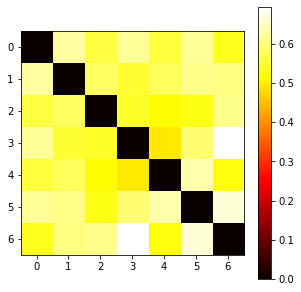

In [0]:
plt.figure(figsize = (5,5))
plt.imshow(accuracyPairwise+np.transpose(accuracyPairwise), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Train model on all classes

In [11]:
class2Cons = [1,2,3,4,5,6,7]
nClasses = len(class2Cons)
display(class2Cons)

X_train, X_test, y_train, y_test = setupDataForNetwork(ME_db_2Dmesh, class2Cons, S, S//2, nTrial_class)
Dataset = [X_train, X_test, y_train, y_test]
# save the fitting history to a file
with open(output_dir+"/CascadeModel_trainData.pickle", 'wb') as file_pi:
  pickle.dump(Dataset, file_pi)

# define model
model = cascadeModel(X_train, nClasses, dropout_rate=dropout_rate, opt=keras.optimizers.Adam(learning_rate=learning_rate))

# define early stopping and checkpoints
from keras.callbacks import ModelCheckpoint, EarlyStopping
outputFile = output_dir+"/CascadeModel_S"+str(S)+"_C1to7_"+"Epochs"+str(nEpochs)+".h5"
checkpoint = ModelCheckpoint(outputFile, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

# fit network
targetsOneHot = to_categorical(y_train-1)
history = model.fit(X_train, targetsOneHot, epochs=nEpochs, batch_size=64, verbose=1, validation_split=0.2, callbacks=[checkpoint, early])
# evaluate model
targetsOneHot = to_categorical(y_test-1)
_, accuracy = model.evaluate(X_test, targetsOneHot, batch_size=64, verbose=1)
display(accuracy)



# save the fitting history to a file
with open(output_dir+"/CascadeModel_trainHistoryDict", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)



[1, 2, 3, 4, 5, 6, 7]

Train on 211397 samples, validate on 52850 samples
Epoch 1/50
211397/211397 [==============================] - 167s 791us/step - loss: 1.9244 - accuracy: 0.1794 - val_loss: 1.8742 - val_accuracy: 0.2289

Epoch 00001: val_accuracy improved from -inf to 0.22889, saving model to /content/drive/My Drive/Data/Output060520/CascadeModel_S8_C1to7_Epochs50.h5
Epoch 2/50
   192/211397 [..............................] - ETA: 2:58 - loss: 1.8891 - accuracy: 0.2240

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


211397/211397 [==============================] - 161s 762us/step - loss: 1.8257 - accuracy: 0.2593 - val_loss: 1.7399 - val_accuracy: 0.3167

Epoch 00002: val_accuracy improved from 0.22889 to 0.31671, saving model to /content/drive/My Drive/Data/Output060520/CascadeModel_S8_C1to7_Epochs50.h5
Epoch 3/50
211397/211397 [==============================] - 162s 765us/step - loss: 1.6624 - accuracy: 0.3557 - val_loss: 1.5863 - val_accuracy: 0.3902

Epoch 00003: val_accuracy improved from 0.31671 to 0.39018, saving model to /content/drive/My Drive/Data/Output060520/CascadeModel_S8_C1to7_Epochs50.h5
Epoch 4/50
211397/211397 [==============================] - 161s 760us/step - loss: 1.4426 - accuracy: 0.4623 - val_loss: 1.4193 - val_accuracy: 0.4661

Epoch 00004: val_accuracy improved from 0.39018 to 0.46611, saving model to /content/drive/My Drive/Data/Output060520/CascadeModel_S8_C1to7_Epochs50.h5
Epoch 5/50
211397/211397 [==============================] - 162s 766us/step - loss: 1.2035 - acc

0.8498228788375854

In [0]:
with open(output_dir+"/CascadeModel_trainData.pickle", 'wb') as file_pi:
  pickle.dump(Dataset, file_pi)

# plot training/validation loss and accuracy

(0.0, 1.0)

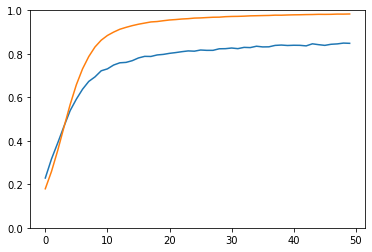

In [20]:
plt.plot(history['val_accuracy'])
plt.plot(history['accuracy'])
plt.ylim((0, 1))

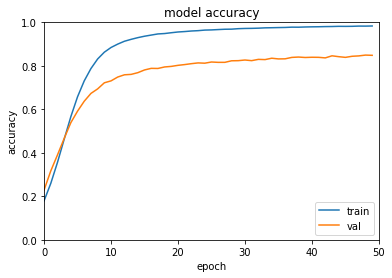

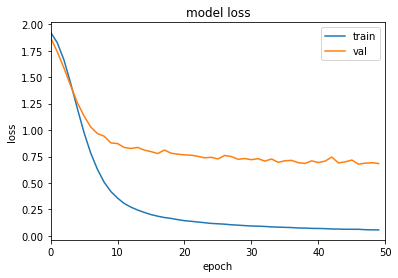

In [22]:
with open(output_dir+"/CascadeModel_trainHistoryDict", 'rb') as f:
  history = pickle.load(f)

# summarize history for accuracy
f = plt.figure()
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.xlim((0, 50))
plt.ylim((0, 1))
plt.show()
f.savefig(output_dir+"/modelAccuracy.pdf", bbox_inches='tight')

# summarize history for loss
f = plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.xlim((0, 50))
#plt.ylim((0, 1))
plt.show()
f.savefig(output_dir+"/modelLoss.pdf", bbox_inches='tight')

# Generate the inputs, targets, and windows before splitting into training and testing sets

In [7]:
class2Cons = [1,2,3,4,5,6,7]
nClasses = len(class2Cons)
display(class2Cons)
# get the dataset
b = sliding_window(np.arange(nFrames), S, S//2)
nWin = b.shape[0]
inputs, targets, wins = genAllDat(ME_db_2Dmesh, b, class2Cons, nClasses, nTrial_class, nWin, S, nX, nY)

[1, 2, 3, 4, 5, 6, 7]

# Save the inputs, targets, and windows into pickle files

In [13]:
outputFile = ["/inputs_S"+str(S)+"_C1to7.h5", \
              "/targets_S"+str(S)+"_C1to7.h5", \
              "/wins_S"+str(S)+"_C1to7.h5"]

dat = [inputs, targets, wins]

t1 = time.time()
for i in range(0,3):
  f = open(output_dir+outputFile[i], "wb")
  i_str = pickle.dumps(dat[i])
  f_size = sys.getsizeof(i_str)
  f.write(i_str)
  f.close()
  print("Finished writing %.2f MB of data to %s in %f s" % (f_size, outputFile[i], time.time()-t1))

Finished writing 1712322057.00 MB of data to /inputs_S8_C1to7.h5 in 14.142479 s
Finished writing 2642666.00 MB of data to /targets_S8_C1to7.h5 in 14.364438 s
Finished writing 2642666.00 MB of data to /wins_S8_C1to7.h5 in 14.454746 s
